In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import torch, numpy as np, random
seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

In [ ]:
df = pd.read_csv('training_dataset.csv',sep=";")
df

FileNotFoundError: [Errno 2] No such file or directory: 'training_dataset.csv'

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df['datetime'] = pd.to_datetime(df['Date'].astype(str)+" "+df['Time'],
                  format='%Y%m%d %H:%M:%S')

In [ ]:
test_df1 = pd.read_csv("final_evaluation_dataset.csv",sep=";")
test_df2 = pd.read_csv("evaluation_dataset.csv",sep=";")
combined_df = pd.concat([test_df1, test_df2], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=["DP_ID", "PORTAL", "Date", "Time"])
combined_df = combined_df.sort_values(by=["PORTAL", "Date", "Time"]).reset_index(drop=True)
combined_df.to_csv("combined_evaluation_dataset.csv", index=False)

In [ ]:
test_df = pd.read_csv("combined_evaluation_dataset.csv",sep=",")
test_df['datetime'] = pd.to_datetime(test_df['Date'].astype(str)+" "+test_df['Time'],
                  format='%Y%m%d %H:%M:%S')

## Portal Aggregation

In [ ]:
global_start = pd.Timestamp('2021-06-01 00:00:00')
global_end = pd.Timestamp('2021-12-31 23:59:00')
full_index = pd.date_range(start=global_start, end=global_end, freq='1min')
mask = (full_index.time >= pd.to_datetime("04:00:00").time()) & (full_index.time <= pd.to_datetime("10:00:00").time())
peak_index = full_index[mask]

In [ ]:
test_start = pd.Timestamp('2022-01-01 00:00:00')
test_end = pd.Timestamp('2022-06-30 23:59:00')
test_full_index = pd.date_range(start=test_start, end=test_end, freq='1min')
mask = (test_full_index.time >= pd.to_datetime("04:00:00").time()) & (test_full_index.time <= pd.to_datetime("10:00:00").time())
test_peak_index = test_full_index[mask]

In [ ]:
def check_missing_minutes(df,dp_id,peak_index=peak_index):

  d = (df.loc[df["DP_ID"] == dp_id, ["datetime", "FLOW", "SPEED_MS_AVG", "PORTAL"]]
           .dropna(subset=["datetime"])
           .sort_values("datetime")
           .set_index("datetime"))

  d = d[~d.index.duplicated(keep="first")]
  d = d.loc[(d.index >= peak_index.min()) & (d.index <= peak_index.max())]

  missing_index = peak_index.difference(d.index)

  actual_minutes = len(d)
  expected_minutes = len(peak_index)
  missing_minutes = len(missing_index)
  missing_ratio = missing_minutes / expected_minutes * 100

  return {
        "DP_ID": dp_id,
        "expected_minutes": expected_minutes,
        "actual_minutes": actual_minutes,
        "missing_minutes": missing_minutes,
        "missing_ratio(%)": round(missing_ratio, 2)
    }

def check_all_dp_missing(df,peak_index=peak_index):
    result = []
    for dp in sorted(df["DP_ID"].unique()):
        result.append(check_missing_minutes(df, dp, peak_index=peak_index))
    return pd.DataFrame(result).sort_values("missing_ratio(%)", ascending=False)

check = check_all_dp_missing(df)
print(check)

In [ ]:
test_check = check_all_dp_missing(test_df,peak_index=test_peak_index)
print(test_check)

In [ ]:
def make_dp_full(df, dp_id, peak_index=peak_index):
    d = (df.loc[df["DP_ID"]==dp_id, ["datetime","FLOW","SPEED_MS_AVG","PORTAL"]]
           .dropna(subset=["datetime"])
           .sort_values("datetime")
           .set_index("datetime"))
    d = d[~d.index.duplicated(keep="first")]
    d = d.loc[(d.index>=peak_index.min()) & (d.index<=peak_index.max())]

    d = d.reindex(peak_index)
    d.index.name = "datetime"

    d["PORTAL"] = df.loc[df["DP_ID"]==dp_id, "PORTAL"].dropna().iloc[0]
    return d

def make_all_dp_full(df,peak_index=peak_index):
    result = []
    for dp in sorted(df["DP_ID"].unique()):
      dp_full = make_dp_full(df,dp,peak_index=peak_index)
      dp_full["DP_ID"] = dp
      result.append(dp_full)

    all_dp_full = pd.concat(result)
    all_dp_full.index.name = "datetime"
    return all_dp_full

all_dp_full = make_all_dp_full(df)
all_dp_full

In [ ]:
all_test_dp_full = make_all_dp_full(test_df,peak_index=test_peak_index)
all_test_dp_full

In [ ]:
all_dp_full.isna().sum()

In [ ]:
all_test_dp_full.isna().sum()

In [ ]:
grp = all_dp_full.groupby(["PORTAL","datetime"],sort=True)

# aggregate flow (sum)
flow_agg = grp["FLOW"].sum(min_count=1).rename("FLOW")

# aggregate speed （weighted)
def weighted_speed(g):
  speed = g["SPEED_MS_AVG"]
  flow = g["FLOW"]
  mask = speed.notna() & flow.notna() & (flow>0)
  if mask.any():
    return np.average(speed[mask], weights=flow[mask])
  else:
    return np.nan

speed_agg = grp.apply(weighted_speed).rename("SPEED_MS_AVG")

portal_minute = pd.concat([flow_agg,speed_agg],axis=1).reset_index()
portal_minute

In [ ]:
portal_minute.to_csv("portal_minute.csv", index=False)

In [ ]:
test_grp = all_test_dp_full.groupby(["PORTAL","datetime"],sort=True)

# aggregate flow (sum)
flow_agg = test_grp["FLOW"].sum(min_count=1).rename("FLOW")
# aggregate speed (weighted)
speed_agg = test_grp.apply(weighted_speed).rename("SPEED_MS_AVG")
portal_minute_test = pd.concat([flow_agg,speed_agg],axis=1).reset_index()
portal_minute_test

In [ ]:
portal_minute_test.to_csv("portal_minute_test.csv", index=False)

In [ ]:
portal_minute.info()

In [ ]:
portal_minute.isna().sum()

In [ ]:
portal_minute_test.info()

In [ ]:
portal_minute_test.isna().sum()

## Descriptive Analysis (Before Imputation)

In [ ]:
pm = pd.read_csv("portal_minute.csv")
pm_test = pd.read_csv("portal_minute_test.csv")
pm["datetime"] = pd.to_datetime(pm["datetime"])
pm_test["datetime"] = pd.to_datetime(pm_test["datetime"])

### Fow & Speed Distribution (Hist)

In [ ]:
plt.rcParams["figure.dpi"] = 150
sns.set(context="notebook", style="whitegrid")

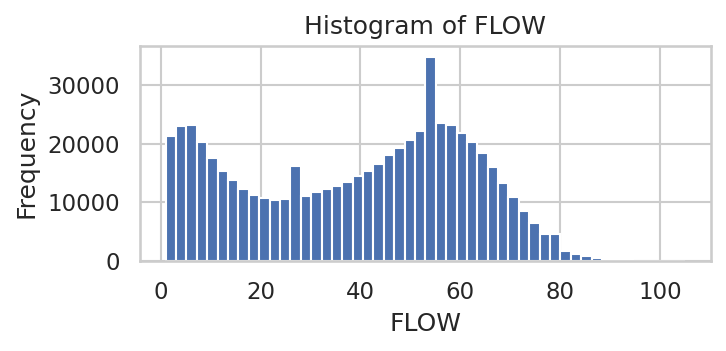

In [ ]:
plt.figure(figsize=(5,2.5))
pm["FLOW"].dropna().plot(kind="hist", bins=50)
plt.xlabel("FLOW")
plt.title("Histogram of FLOW")
plt.savefig("hist_flow.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

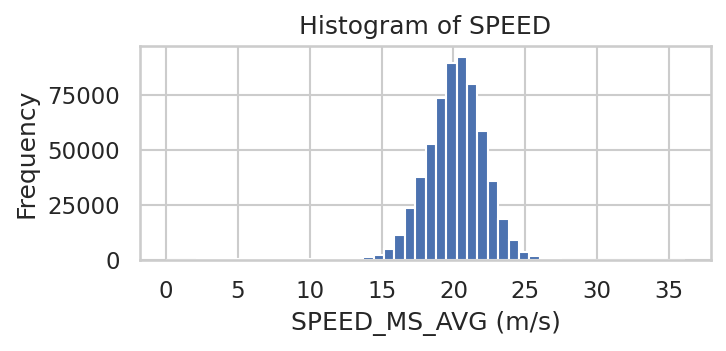

In [ ]:
plt.figure(figsize=(5,2.5))
pm["SPEED_MS_AVG"].dropna().plot(kind="hist", bins=50)
plt.xlabel("SPEED_MS_AVG (m/s)")
plt.title("Histogram of SPEED")
plt.savefig("hist_speed.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

### Temporal Analysis

In [ ]:
def add_time_cols(df: pd.DataFrame) -> pd.DataFrame:
  d = df.copy()
  d["year"] = d["datetime"].dt.year
  d["month"] = d["datetime"].dt.month
  d["day"] = d["datetime"].dt.day
  d["hour"] = d["datetime"].dt.hour
  d["minute"] = d["datetime"].dt.minute
  d["dow"] = d["datetime"].dt.dayofweek
  d["is_weekend"] = (d["dow"] >= 5)
  return d

In [ ]:
def temporal_analysis(df:pd.DataFrame):
  d = add_time_cols(df)

  # Minute-level intraday average curve (FLOW)
  flow_minute = d.dropna(subset=["FLOW"]).groupby(["hour","minute"])["FLOW"].mean().reset_index()
  flow_minute["tminute"] = flow_minute["hour"]*60 + flow_minute["minute"]

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_minute["tminute"], flow_minute["FLOW"], linewidth=1.0)
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Flow (mean)")
  plt.title("Minute-level average FLOW")
  plt.savefig("minute_level_flow.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Minute-level intraday average curve (SPEED)
  speed_minute = d.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour","minute"])["SPEED_MS_AVG"].mean().reset_index()
  speed_minute["tminute"] = speed_minute["hour"]*60 + speed_minute["minute"]
  plt.figure(figsize=(6,2.2))
  plt.plot(speed_minute["tminute"], speed_minute["SPEED_MS_AVG"], linewidth=1.0)
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Minute-level average SPEED")
  plt.savefig("minute_level_speed", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Hour-level intraday average curve (FLOW)
  flow_hour = d.dropna(subset=["FLOW"]).groupby(["hour"])["FLOW"].mean().reset_index()
  plt.figure(figsize=(6,2.2))
  plt.plot(flow_hour["hour"], flow_hour["FLOW"], marker="o", linewidth=1.0)
  plt.xticks([4,5,6,7,8,9,10], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Flow (mean)")
  plt.title("Hour-level average FLOW")
  plt.tight_layout()

  # Hour-level intraday average curve (SPEED)
  speed_hour = d.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour"])["SPEED_MS_AVG"].mean().reset_index()
  plt.figure(figsize=(6,2.2))
  plt.plot(speed_hour["hour"], speed_hour["SPEED_MS_AVG"], marker="o", linewidth=1.0)
  plt.xticks([4,5,6,7,8,9,10], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Hour-level average SPEED")
  plt.tight_layout()

  ### Distinguish between weekdays and weekends
  # Minute-level intraday average curve (FLOW)
  wd = d[~d["is_weekend"]]
  we = d[d["is_weekend"]]

  flow_minute_wd = wd.dropna(subset=["FLOW"]).groupby(["hour","minute"])["FLOW"].mean().reset_index()
  flow_minute_wd["tminute"] = flow_minute_wd["hour"]*60 + flow_minute_wd["minute"]

  flow_minute_we = we.dropna(subset=["FLOW"]).groupby(["hour","minute"])["FLOW"].mean().reset_index()
  flow_minute_we["tminute"] = flow_minute_we["hour"]*60 + flow_minute_we["minute"]

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_minute_wd["tminute"], flow_minute_wd["FLOW"], linewidth=1.0, label="weekday")
  plt.plot(flow_minute_we["tminute"], flow_minute_we["FLOW"], linewidth=1.0, label="weekend")
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Flow (mean)")
  plt.title("Minute-level average FLOW: Weekday vs Weekend")
  plt.legend()
  plt.savefig("flow_weekday_weekend.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Minute-level intraday average curve (SPEED)
  flow_minute_wd = wd.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour","minute"])["SPEED_MS_AVG"].mean().reset_index()
  flow_minute_wd["tminute"] = flow_minute_wd["hour"]*60 + flow_minute_wd["minute"]

  flow_minute_we = we.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour","minute"])["SPEED_MS_AVG"].mean().reset_index()
  flow_minute_we["tminute"] = flow_minute_we["hour"]*60 + flow_minute_we["minute"]

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_minute_wd["tminute"], flow_minute_wd["SPEED_MS_AVG"], linewidth=1.0, label="weekday")
  plt.plot(flow_minute_we["tminute"], flow_minute_we["SPEED_MS_AVG"], linewidth=1.0, label="weekend")
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Minute-level average SPEED: Weekday vs. Weekend")
  plt.legend()
  plt.savefig("speed_weekday_weekend.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Weakly Heatmap
  piv_flow = d.pivot_table(index="dow", columns="hour", values="FLOW", aggfunc="mean")
  piv_speed = d.pivot_table(index="dow", columns="hour", values="SPEED_MS_AVG", aggfunc="mean")
  plt.figure(figsize=(6.5,2.5))
  sns.heatmap(piv_flow, cmap="viridis", cbar_kws={"label":"FLOW mean"})
  plt.title("Week-Hour heatmap (FLOW)"); plt.xlabel("Hour"); plt.ylabel("Day of Week (0=Mon)")
  plt.savefig("flow_heatmap.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()
  plt.figure(figsize=(6.5,2.5))
  sns.heatmap(piv_speed, cmap="viridis", cbar_kws={"label":"Speed mean (m/s)"})
  plt.title("Weekly-Hour heatmap (SPEED)"); plt.xlabel("Hour"); plt.ylabel("Day of Week (0=Mon)")
  plt.savefig("speed_heatmap.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Monthly
  flow_month = d.dropna(subset=["FLOW"]).groupby(["year","month"])["FLOW"].mean().reset_index()
  flow_month["ym"] = flow_month["year"].astype("str") + "-" + flow_month["month"].astype("str")

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_month["ym"], flow_month["FLOW"], linewidth=1.0)
  plt.xticks(rotation=0)
  plt.xlabel("Month")
  plt.ylabel("Flow (mean)")
  plt.title("Monthly average FLOW")
  plt.tight_layout()

  speed_month = d.dropna(subset=["SPEED_MS_AVG"]).groupby(["year","month"])["SPEED_MS_AVG"].mean().reset_index()
  speed_month["ym"] = speed_month["year"].astype("str") + "-" + speed_month["month"].astype("str")
  plt.figure(figsize=(6,2.2))
  plt.plot(speed_month["ym"], speed_month["SPEED_MS_AVG"], linewidth=1.0)
  plt.xticks(rotation=0)
  plt.xlabel("Month")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Monthly average SPEED")
  plt.tight_layout()

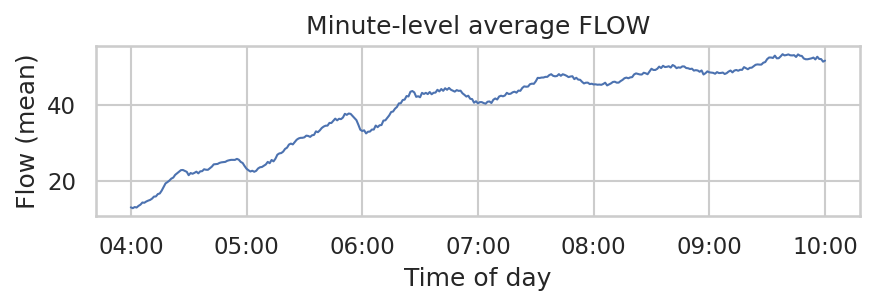

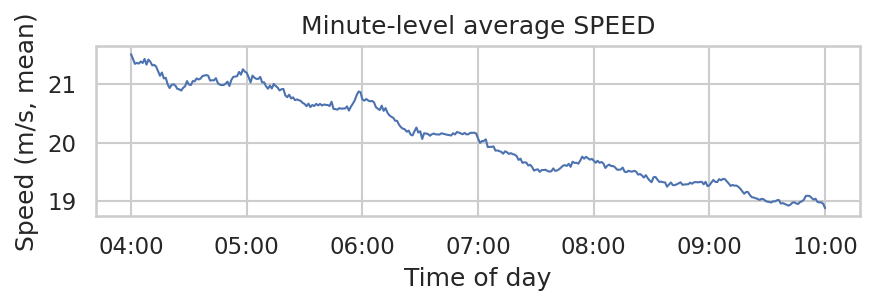

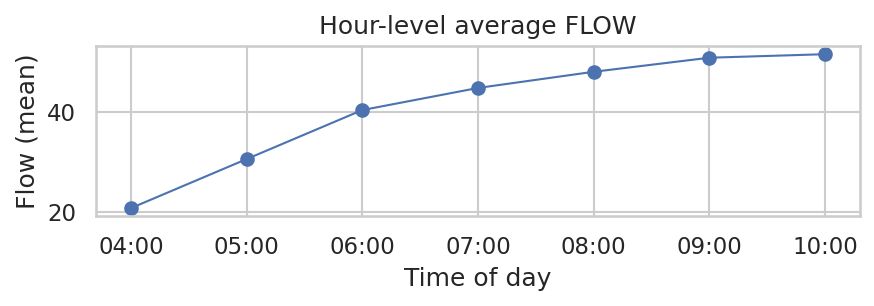

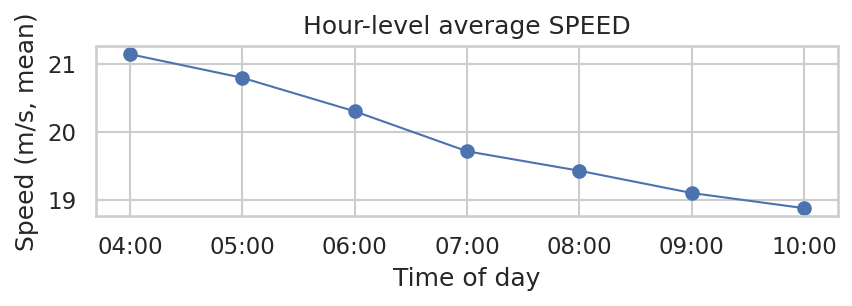

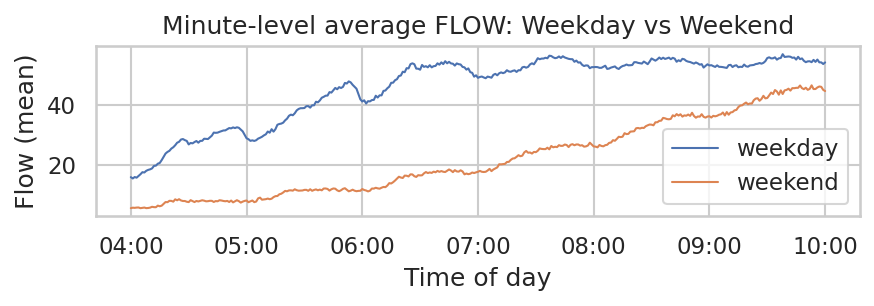

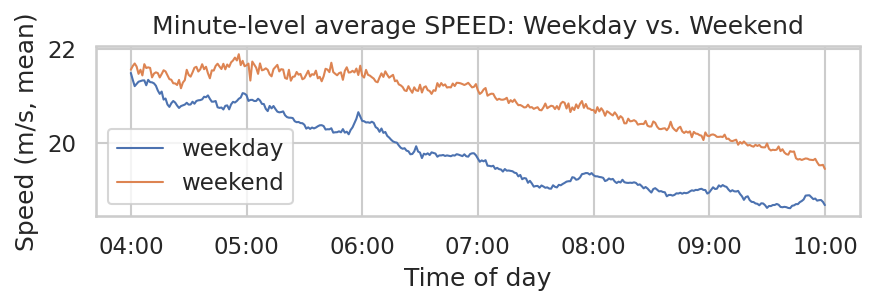

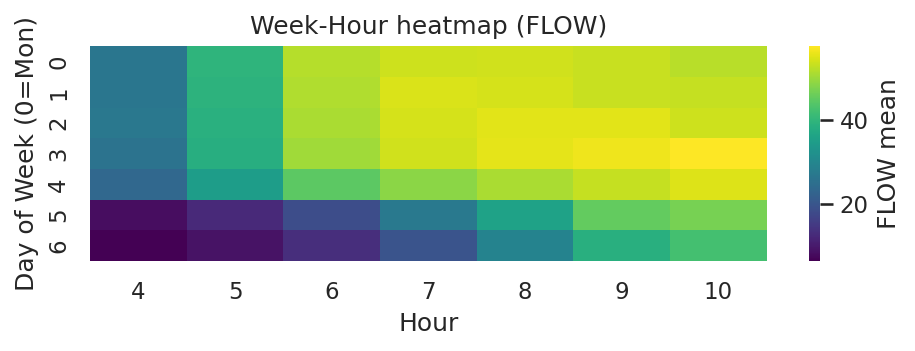

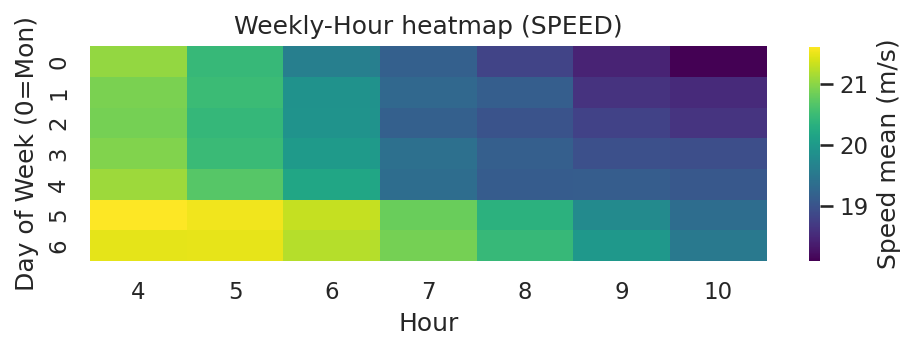

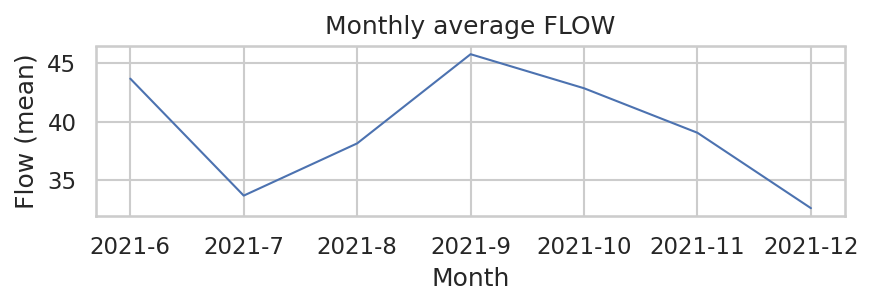

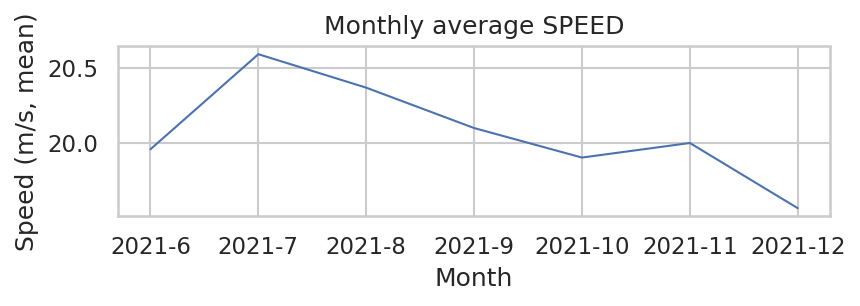

In [ ]:
temporal_analysis(pm)

### Spatial Analysis

In [ ]:
def spatial_analysis(df:pd.DataFrame):
  d = df.copy()

  # Flow by portal
  plt.figure(figsize=(7,6))
  plt.subplot(2,1,1)
  sns.boxplot(data=d.dropna(subset=["FLOW"]), x="PORTAL", y="FLOW", fliersize=1)
  plt.title("FLOW by PORTAL")
  plt.xlabel("")
  plt.ylabel("Flow (mean)")
  plt.xticks(rotation=30, ha="right")
  plt.savefig("flow_portal.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Speed by portal
  plt.subplot(2,1,2)
  sns.boxplot(data=d.dropna(subset=["SPEED_MS_AVG"]), x="PORTAL", y="SPEED_MS_AVG", fliersize=1)
  plt.title("SPEED by PORTAL")
  plt.xlabel(" ")
  plt.ylabel("Speed (m/s, mean)")
  plt.xticks(rotation=30, ha="right")
  plt.savefig("speed_portal.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Consider downstreams and upstreams
  portal_ids = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
          "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]

  flow_portal = d.dropna(subset=["FLOW"]).groupby("PORTAL")["FLOW"].mean().reindex(portal_ids)
  plt.figure(figsize=(6.5,2.2))
  plt.plot(flow_portal.index, flow_portal.values, marker="o")
  plt.title("FLOW gradient along river (downstream → upstream)")
  plt.xticks(rotation=30, ha="right")
  plt.ylabel("FLOW mean")
  plt.tight_layout()

  speed_portal = d.dropna(subset=["SPEED_MS_AVG"]).groupby("PORTAL")["SPEED_MS_AVG"].mean().reindex(portal_ids)
  plt.figure(figsize=(6.5,2.2))
  plt.plot(speed_portal.index, speed_portal.values, marker="o")
  plt.title("SPEED gradient along river (downstream → upstream)")
  plt.xticks(rotation=30, ha="right")
  plt.ylabel("Speed mean (m/s)")
  plt.tight_layout()
  # Results from these two graphs can be obtained from boxplots, so can delete these two line charts

  #
  pivot_flow = d.pivot_table(index="datetime", columns="PORTAL", values="FLOW", aggfunc="mean")
  pivot_speed = d.pivot_table(index="datetime", columns="PORTAL", values="SPEED_MS_AVG", aggfunc="mean")

  corr_flow = pivot_flow.corr()
  corr_speed = pivot_speed.corr()

  plt.figure(figsize=(5,4))
  sns.heatmap(corr_flow, cmap="coolwarm", vmin=-1, vmax=1, square=True)
  plt.title("Correlation matrix (FLOW)")
  plt.savefig("flow_cmatrix.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  plt.figure(figsize=(5,4))
  sns.heatmap(corr_speed, cmap="coolwarm", vmin=-1, vmax=1, square=True)
  plt.title("Correlation matrix (SPEED)")
  plt.savefig("speed_cmatrix.png", dpi=300, bbox_inches="tight")
  plt.tight_layout();

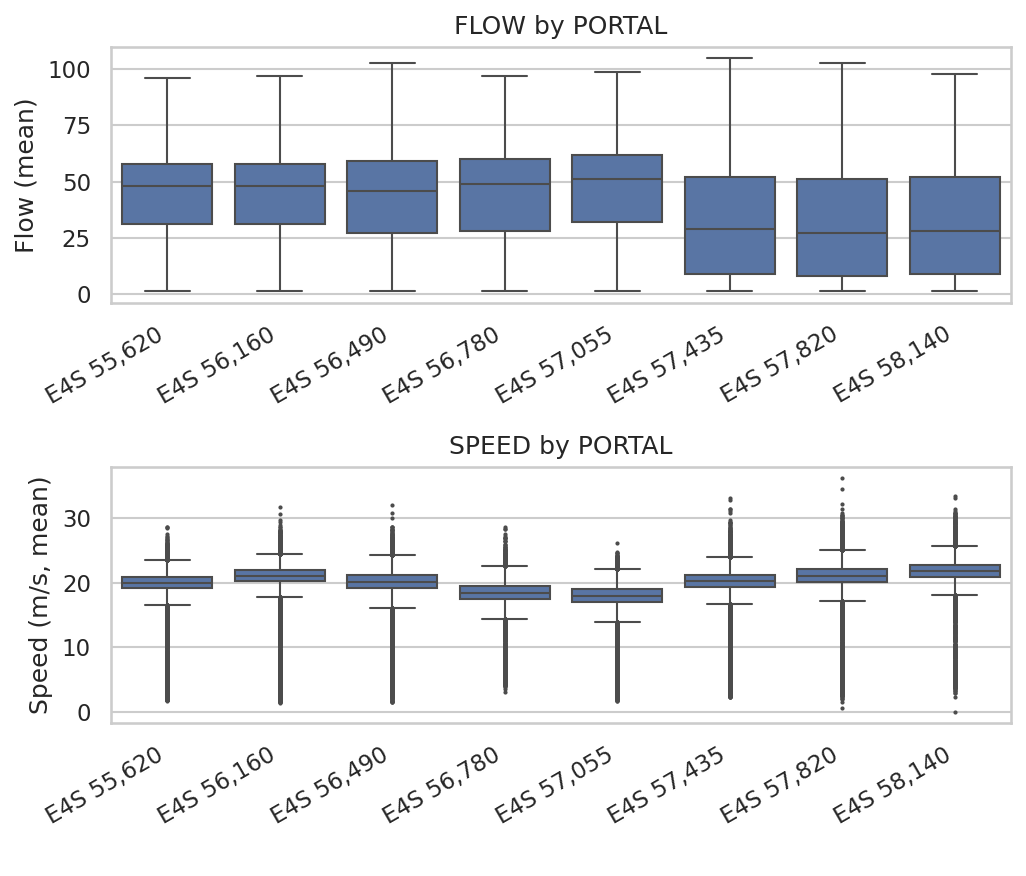

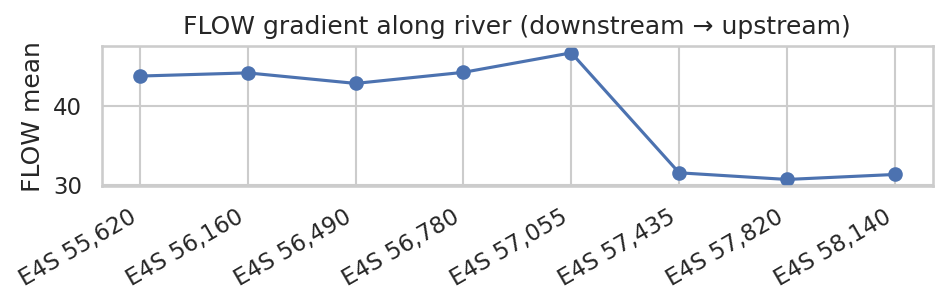

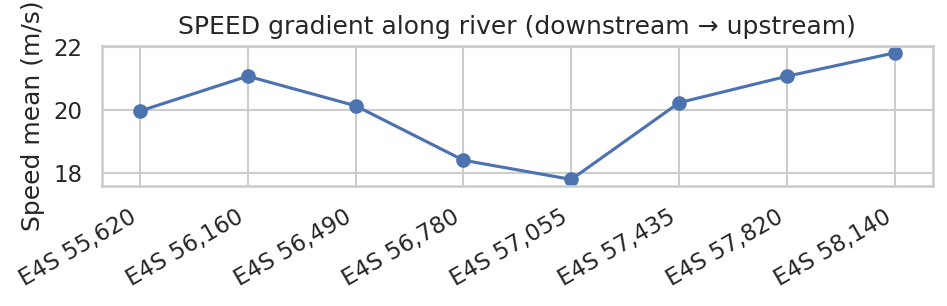

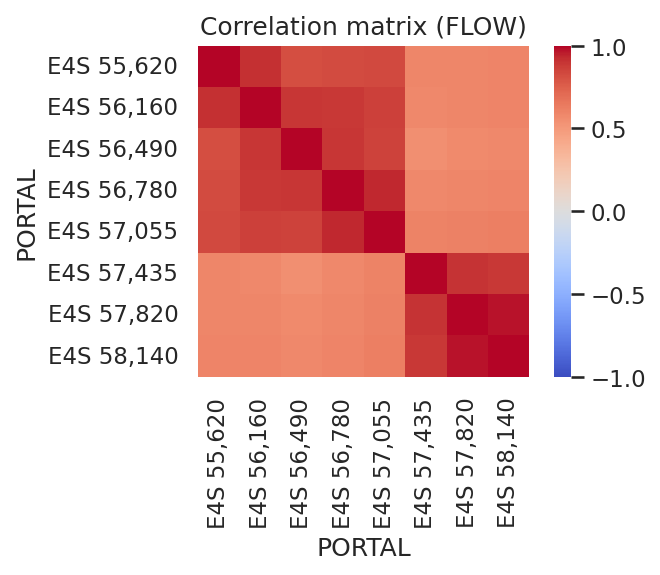

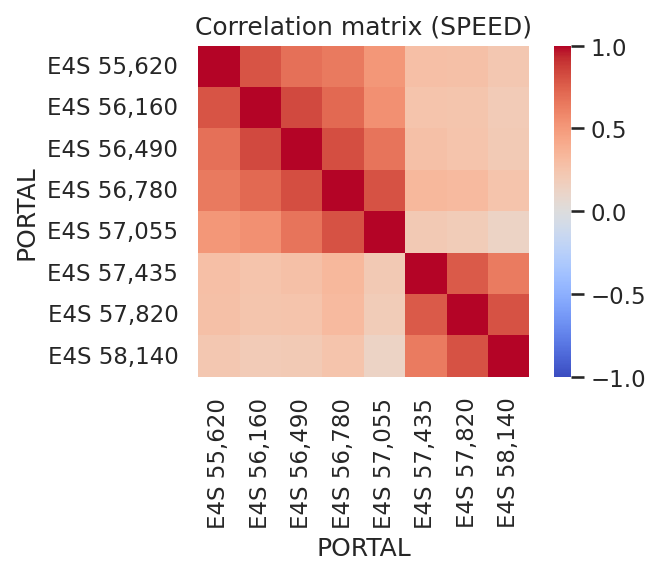

In [ ]:
spatial_analysis(pm)

## Handling Missing Values

In [ ]:
df = portal_minute.sort_values(["PORTAL","datetime"]).copy()

# split training and validation set
VAL_START = pd.Timestamp("2021-12-01 04:00:00")
VAL_END = pd.Timestamp("2021-12-31 10:00:00")

train_df = df[df["datetime"] < VAL_START]
val_df = df[(df["datetime"] >= VAL_START) & (df["datetime"] <= VAL_END)]
test_df = portal_minute_test.sort_values(["PORTAL","datetime"]).copy()

# calculate statistics on training set (in order to avoid information leakage)
train_df["Hour"] = train_df["datetime"].dt.hour
train_df["Minute"] = train_df["datetime"].dt.minute
# same portal same hour & minute: flow & speed median
train_pt_flow = train_df.groupby(["PORTAL","Hour","Minute"])["FLOW"].median()
train_pt_speed = train_df.groupby(["PORTAL","Hour","Minute"])["SPEED_MS_AVG"].median()

# first fill with train_df
train_df.set_index("datetime", inplace=True)
train_df["SPEED_MS_AVG"] = (train_df.groupby("PORTAL")["SPEED_MS_AVG"]
                   .transform(lambda s: s.interpolate(method="time", limit=2))
)
train_df.reset_index(inplace=True)

train_df = train_df.merge(train_pt_speed, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
train_df["SPEED_MS_AVG"] = train_df["SPEED_MS_AVG"].fillna(train_df["SPEED_MS_AVG_median"])

train_df = train_df.merge(train_pt_flow, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
train_df["FLOW"] = train_df["FLOW"].fillna(train_df["FLOW_median"])
train_df["FLOW"] = train_df["FLOW"].fillna(0.0)

# Speed: time-based interpolation within each PORTAL for short gaps(<=2 mins)
val_df.set_index("datetime",inplace=True)
val_df["SPEED_MS_AVG"] = (val_df.groupby("PORTAL")["SPEED_MS_AVG"]
                 .transform(lambda s: s.interpolate(method="time", limit=2)))
val_df.reset_index(inplace=True)

test_df.set_index("datetime",inplace=True)
test_df["SPEED_MS_AVG"] = (test_df.groupby("PORTAL")["SPEED_MS_AVG"]
                 .transform(lambda s: s.interpolate(method="time", limit=2)))
test_df.reset_index(inplace=True)

# Speed: for remaining nans, fill the historical median of training set at the same portal and same time
val_df["Hour"] = val_df["datetime"].dt.hour
val_df["Minute"] = val_df["datetime"].dt.minute
val_df = val_df.merge(train_pt_speed, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
val_df["SPEED_MS_AVG"] = val_df["SPEED_MS_AVG"].fillna(val_df["SPEED_MS_AVG_median"])

test_df["Hour"] = test_df["datetime"].dt.hour
test_df["Minute"] = test_df["datetime"].dt.minute
test_df = test_df.merge(train_pt_speed, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
test_df["SPEED_MS_AVG"] = test_df["SPEED_MS_AVG"].fillna(test_df["SPEED_MS_AVG_median"])

# Flow: first, fill the historical median of training set at the same portal and same time
val_df = val_df.merge(train_pt_flow, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
val_df["FLOW"] = val_df["FLOW"].fillna(val_df["FLOW_median"])

test_df = test_df.merge(train_pt_flow, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
test_df["FLOW"] = test_df["FLOW"].fillna(test_df["FLOW_median"])

# Flow: for remaining nans, fill 0
val_df["FLOW"] = val_df["FLOW"].fillna(0.0)
test_df["FLOW"] = test_df["FLOW"].fillna(0.0)

val_df.drop(["Hour","Minute","SPEED_MS_AVG_median","FLOW_median"],axis=1,inplace=True)
test_df.drop(["Hour","Minute","SPEED_MS_AVG_median","FLOW_median"],axis=1,inplace=True)
train_df.drop(["Hour","Minute","SPEED_MS_AVG_median","FLOW_median"],axis=1,inplace=True)

In [ ]:
train_df.to_csv("train_df.csv",index=False)
val_df.to_csv("val_df.csv",index=False)
test_df.to_csv("test_df.csv",index=False)

## Descriptive Analysis (After Imputation/Verify the rationality of interpolation）

In [ ]:
pm_filled = pd.concat([train_df, val_df])

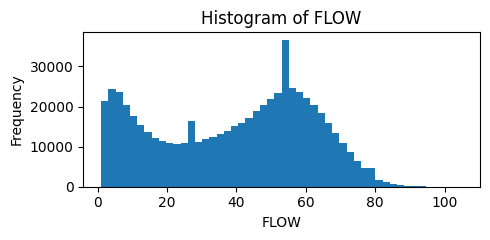

In [ ]:
plt.figure(figsize=(5,2.5))
pm_filled["FLOW"].plot(kind="hist", bins=50)
plt.xlabel("FLOW")
plt.title("Histogram of FLOW")
plt.tight_layout()

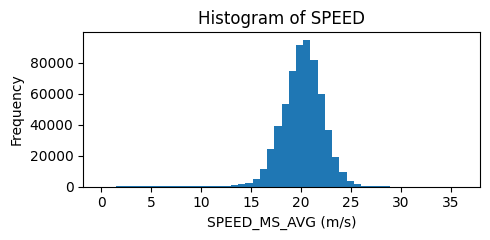

In [ ]:
plt.figure(figsize=(5,2.5))
pm_filled["SPEED_MS_AVG"].plot(kind="hist", bins=50)
plt.xlabel("SPEED_MS_AVG (m/s)")
plt.title("Histogram of SPEED")
plt.tight_layout()

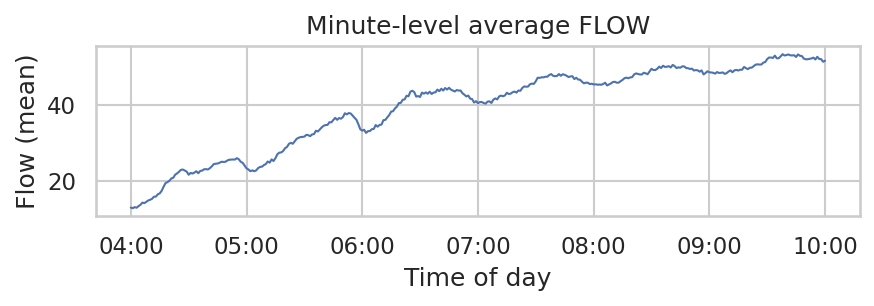

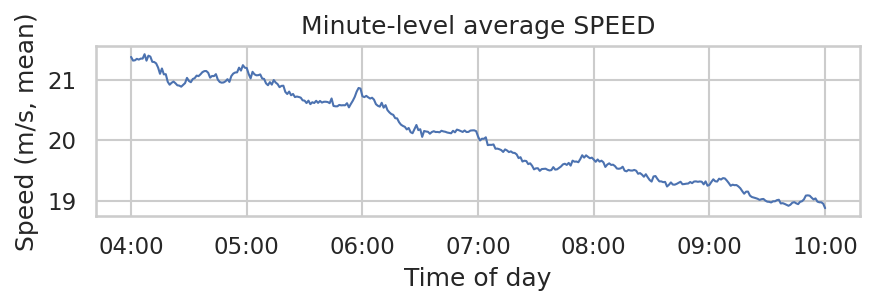

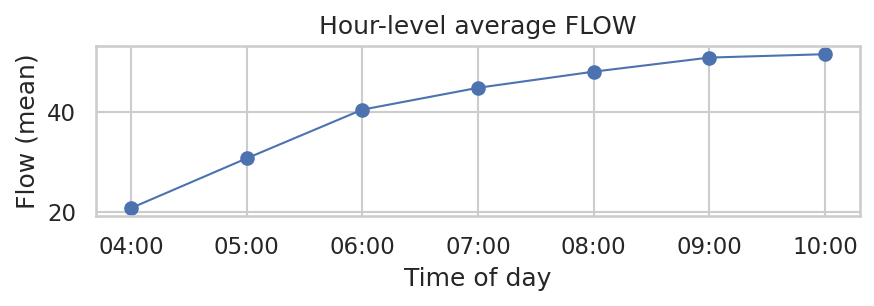

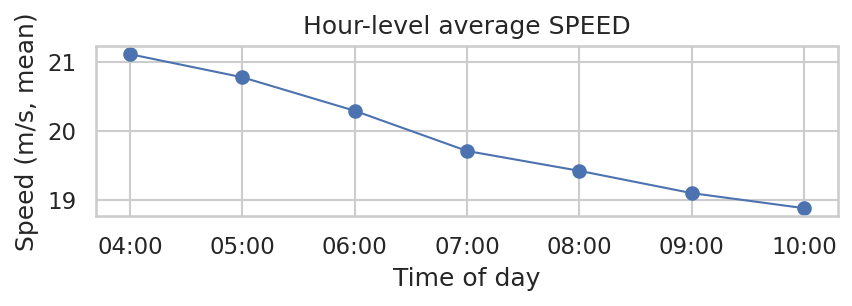

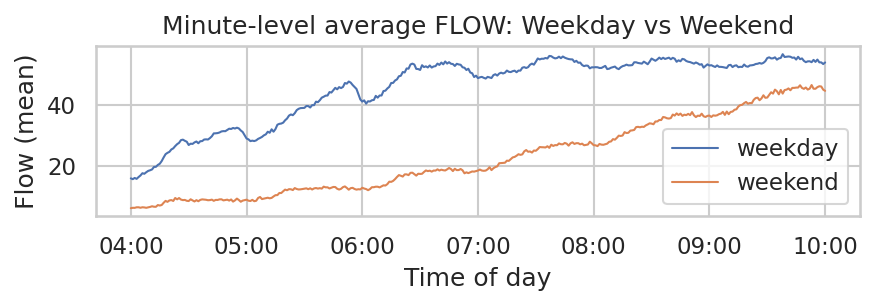

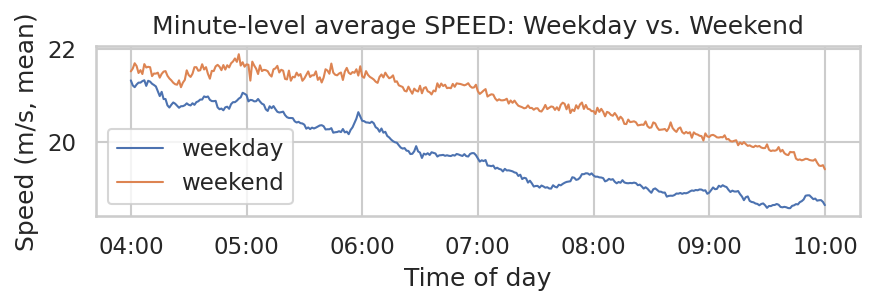

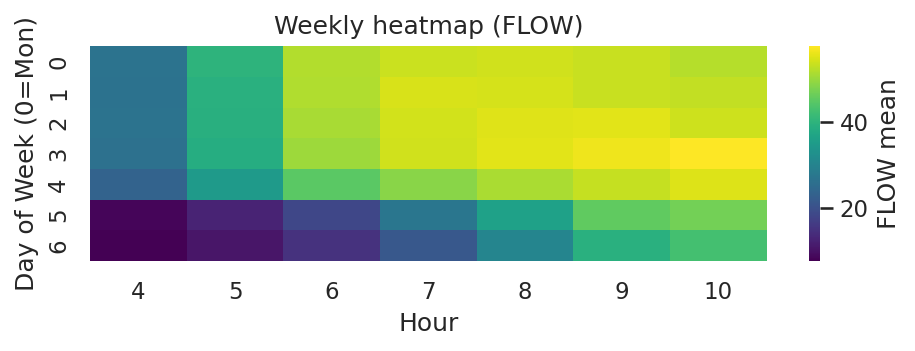

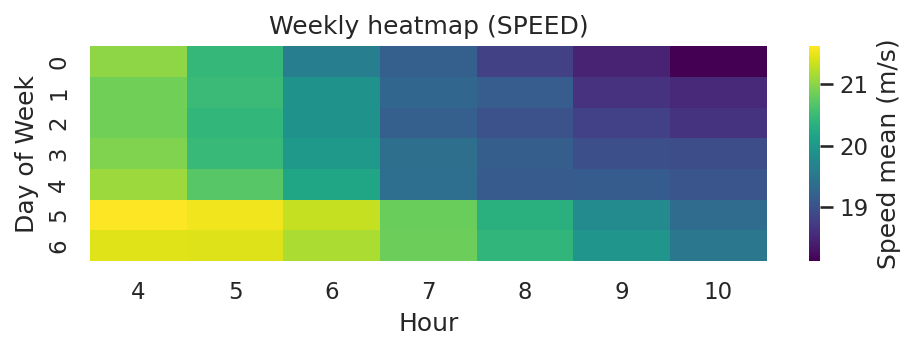

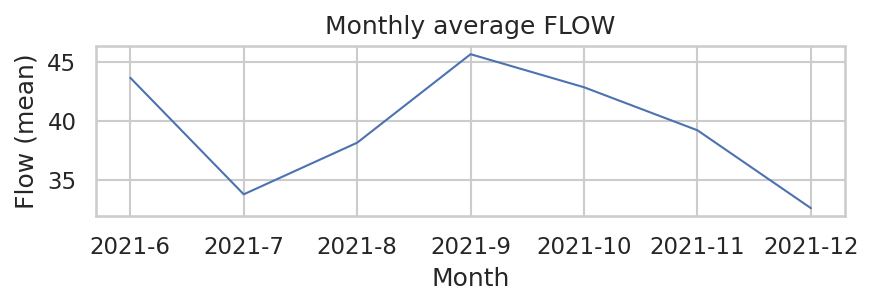

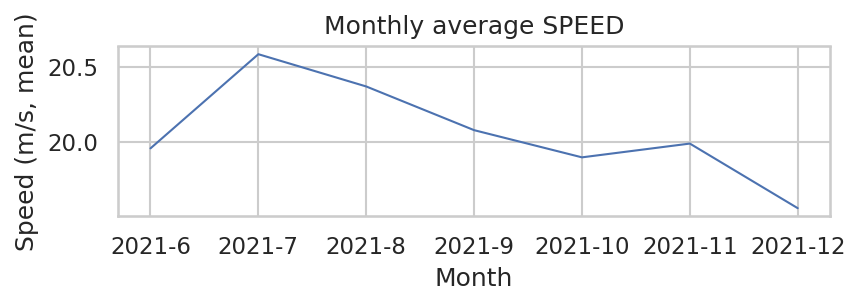

In [ ]:
temporal_analysis(pm_filled)

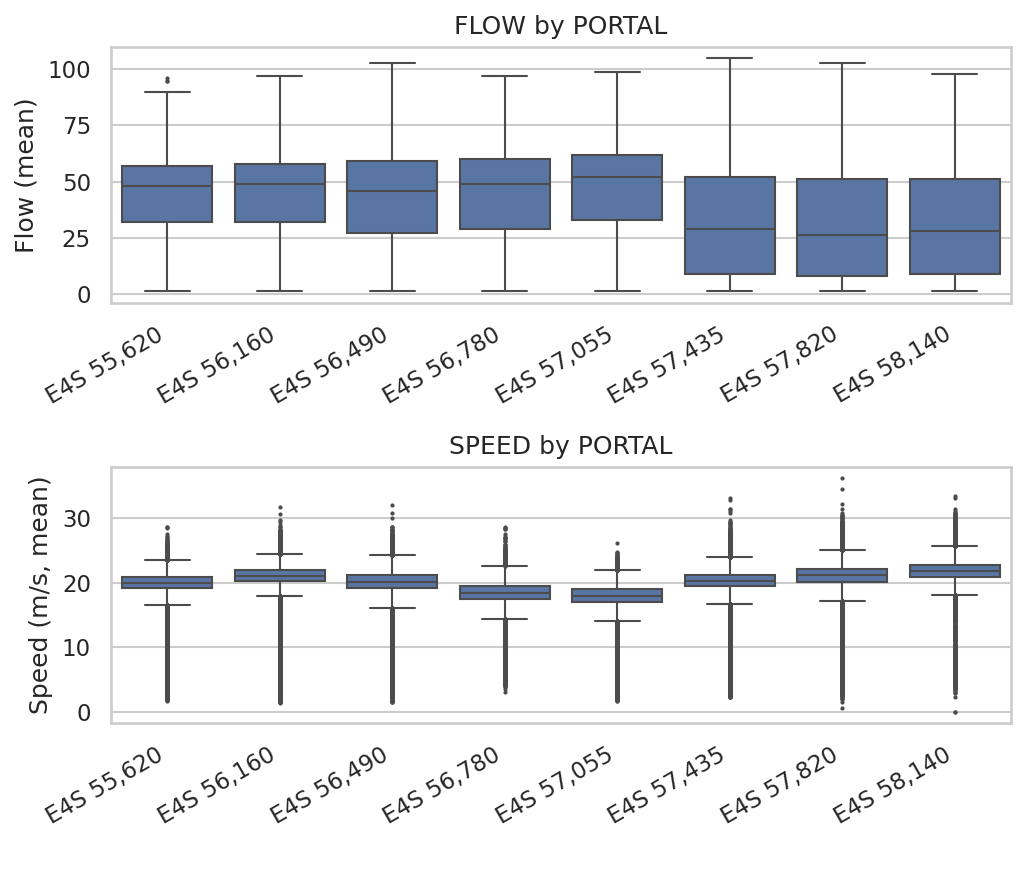

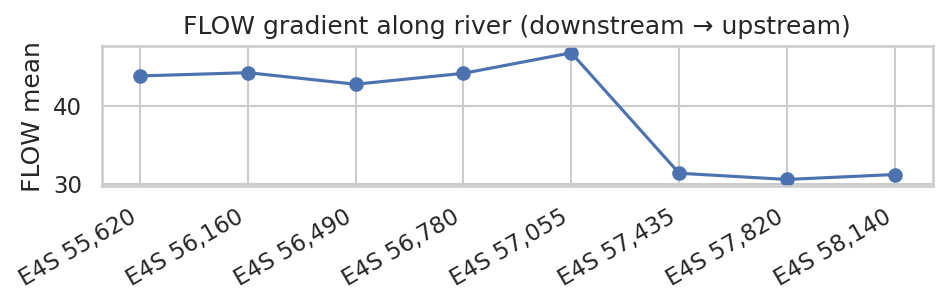

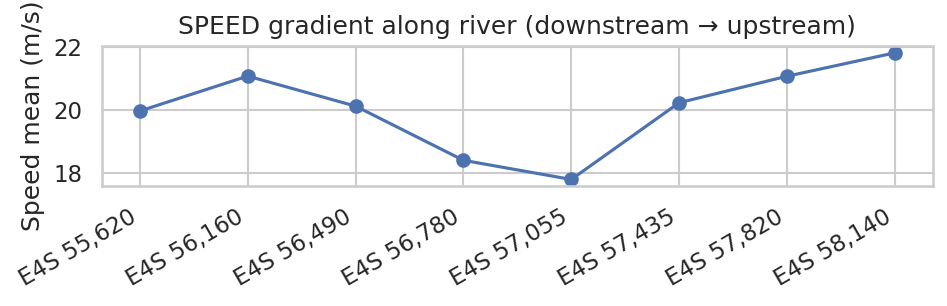

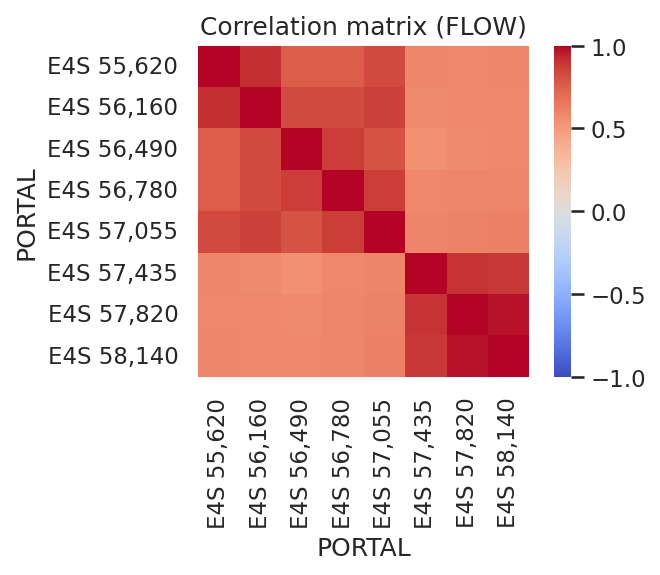

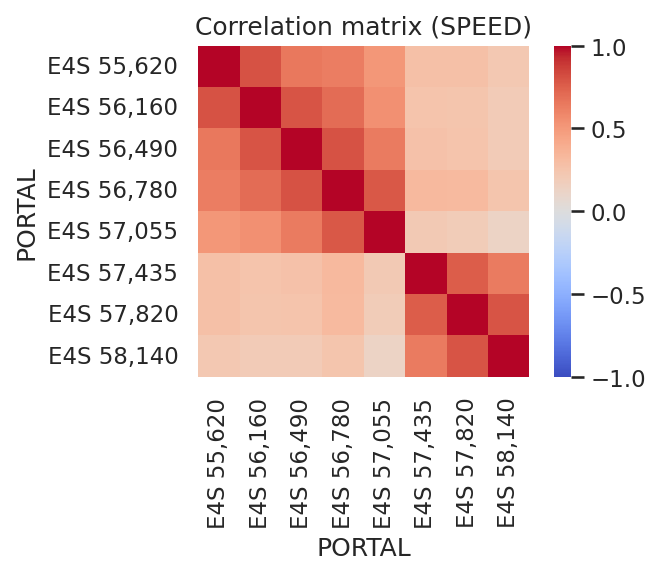

In [ ]:
spatial_analysis(pm_filled)

## Help Functions

#### **Setup device agnostic code**

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### **Create a function to Time our experiments**

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = device):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

#### **Functionize the training and test loop**

In [ ]:
def train_step(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        device:torch.device=device):

  train_loss = 0
  model.to(device)
  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lstm_all.parameters(), 1.0)
    optimizer.step()

  train_loss /= len(data_loader)

  print(f"Train loss: {train_loss:.5f}")
  return train_loss


def test_step(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        device:torch.device=device):

  test_loss = 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y).item()

    test_loss /= len(data_loader)

  print(f"Test loss: {test_loss:.5f}")
  return test_loss

#### **Functionize Evaluation**

In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def eval_model(model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device = device,
        scaler=None,
        horizons:list=None,
        feature_names:list=None):

    model.to(device)
    model.eval()

    y_true_list = []
    y_pred_list= []
    loss = 0

    with torch.inference_mode():
      for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss += loss_fn(y_pred, y).item()
        y_true_list.append(y.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())


    loss /= len(data_loader)

    metrics = {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss}

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    # inverse tranform
    if scaler is not None:
      if y_true.ndim ==3:  # [N,H,D]
        N, H, D = y_true.shape
        y_true_inv = scaler.inverse_transform(y_true.reshape(-1,D)).reshape(N,H,D)
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,D)).reshape(N,H,D)
      else:
        N, H = y_true.shape  # [N,H]
        y_true_inv = scaler.inverse_transform(y_true.reshape(-1,1)).reshape(N,H)
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(N,H)
    else:
      y_true_inv, y_pred_inv = y_true, y_pred

    # metrics
    if y_true_inv.ndim == 3:
      N, H, D = y_true_inv.shape
      fnames = feature_names[:D]

      # overall
      metrics["MAE_overall"] = mean_absolute_error(y_true_inv.ravel(), y_pred_inv.ravel())
      metrics["RMSE_overall"] = root_mean_squared_error(y_true_inv.ravel(), y_pred_inv.ravel())

      # per feature (flow / speed)
      metrics["MAE_per_feature"] = {fnames[i]: mean_absolute_error(y_true_inv[:,:,i].ravel(), y_pred_inv[:,:,i].ravel()) for i in range(D)}
      metrics["RMSE_per_feature"] = {fnames[i]: root_mean_squared_error(y_true_inv[:,:,i].ravel(), y_pred_inv[:,:,i].ravel()) for i in range(D)}

      # per step (range(horizons))
      mae_per_step  = [mean_absolute_error(y_true_inv[:,i-1,:].ravel(), y_pred_inv[:,i-1,:].ravel()) for i in horizons]
      rmse_per_step = [root_mean_squared_error(y_true_inv[:,i-1,:].ravel(), y_pred_inv[:,i-1,:].ravel()) for i in horizons]
      metrics["MAE_per_step"]  = dict(zip(horizons, mae_per_step))
      metrics["RMSE_per_step"] = dict(zip(horizons, rmse_per_step))

      # —— Aggregate column names with portal into basic features (FLOW/SPEED.MS.AVG) ——
      def _base_feat(name: str):
        if name.startswith("FLOW"):
          return "FLOW"
        if name.startswith("SPEED_MS_AVG") or name.startswith("SPEED"):
          return "SPEED_MS_AVG"
          return name.split("_")[0]

      groups = {}  # {'FLOW': [j1,j2,...], 'SPEED_MS_AVG': [k1,k2,...]}
      for j, name in enumerate(fnames):
        groups.setdefault(_base_feat(name), []).append(j)

      # —— Calculate MAE/RMSE for 'By Feature x By Step (Summarize All Portals) ——
      mae_fps, rmse_fps = {}, {}
      rows = []
      for feat, js in groups.items():
        mae_fps[feat], rmse_fps[feat] = {}, {}
        for idx, h in enumerate(horizons):
          yt = np.concatenate([y_true_inv[:, idx, j].ravel() for j in js])
          yp = np.concatenate([y_pred_inv[:, idx, j].ravel() for j in js])
          mae_v  = mean_absolute_error(yt, yp)
          rmse_v = root_mean_squared_error(yt, yp)

          mae_fps[feat][h]  = mae_v
          rmse_fps[feat][h] = rmse_v
          rows.append({"feature": feat, "horizon": h, "MAE": mae_v, "RMSE": rmse_v})

      metrics["MAE_per_feature_per_step"]  = mae_fps
      metrics["RMSE_per_feature_per_step"] = rmse_fps
      metrics["per_step_df"] = pd.DataFrame(rows)

    else:  # [N,H]
      N, H = y_true_inv.shape
      mae_per_step  = [mean_absolute_error(y_true_inv[:,i-1].ravel(), y_pred_inv[:,i-1].ravel()) for i in horizons]
      rmse_per_step = [root_mean_squared_error(y_true_inv[:,i-1].ravel(), y_pred_inv[:,i-1].ravel()) for i in horizons]

      mae_mean  = np.mean(mae_per_step)
      rmse_mean = np.mean(rmse_per_step)

      metrics.update({
            "MAE_mean": mae_mean,
            "RMSE_mean": rmse_mean,
            "MAE_per_step": mae_per_step,
            "RMSE_per_step": rmse_per_step,
      })

    return metrics, y_true_inv, y_pred_inv

## All-Portals LSTM

In [ ]:
class SimpleLSTM(nn.Module):
  def __init__(self,
         input_size=2,   # 2 features: flow and speed
         hidden_size=64,
         num_layers=1,
         horizon=15,    # prediction_length: len(HORIZIONS)
         out_size=2):    # 2 predict features: flow and speed

    super().__init__()
    self.horizon=horizon
    self.out_size=out_size

    self.lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size,
               num_layers=num_layers,
               batch_first=True)

    self.linear = nn.Linear(in_features=hidden_size,
                 out_features=horizon*out_size)

  def forward(self,x):
    """
      x: [batch_size, seq_len, input_size],

      return: [batch_size, horizon, out_size]
    """

    lstm_out, (h_n,c_n) = self.lstm(x)
    output = self.linear(lstm_out[:,-1,:])   # many to one

    return output.view(-1,self.horizon,self.out_size)

In [ ]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
val_df["datetime"] = pd.to_datetime(val_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

In [ ]:
train_df.sort_values(["datetime","PORTAL"], inplace=True)
train_flow = train_df.pivot(index="datetime", columns="PORTAL", values="FLOW").add_prefix("FLOW_")
train_speed = train_df.pivot(index="datetime", columns="PORTAL", values="SPEED_MS_AVG").add_prefix("SPEED_")
train_flow_speed = pd.concat([train_flow, train_speed], axis=1)

portal_ids = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
        "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]
feature_cols = []
for pid in portal_ids:
  for col in (f"FLOW_{pid}", f"SPEED_{pid}"):
    feature_cols.append(col)

train_flow_speed = train_flow_speed[feature_cols]

In [ ]:
val_df.sort_values(["datetime","PORTAL"], inplace=True)
val_flow = val_df.pivot(index="datetime", columns="PORTAL", values="FLOW").add_prefix("FLOW_")
val_speed = val_df.pivot(index="datetime", columns="PORTAL", values="SPEED_MS_AVG").add_prefix("SPEED_")
val_flow_speed = pd.concat([val_flow, val_speed], axis=1)
val_flow_speed = val_flow_speed[feature_cols]

In [ ]:
test_df.sort_values(["datetime","PORTAL"], inplace=True)
test_flow = test_df.pivot(index="datetime", columns="PORTAL", values="FLOW").add_prefix("FLOW_")
test_speed = test_df.pivot(index="datetime", columns="PORTAL", values="SPEED_MS_AVG").add_prefix("SPEED_")
test_flow_speed = pd.concat([test_flow, test_speed], axis=1)
test_flow_speed = test_flow_speed[feature_cols]

In [ ]:
train_flow_speed.shape, val_flow_speed.shape, test_flow_speed.shape

((66063, 16), (11191, 16), (65341, 16))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.06336
Test loss: 0.05166
Epoch: 1
---------
Train loss: 0.05213
Test loss: 0.05318
Epoch: 2
---------
Train loss: 0.05155
Test loss: 0.05067
Epoch: 3
---------
Train loss: 0.05119
Test loss: 0.05112
Epoch: 4
---------
Train loss: 0.05081
Test loss: 0.05078
Epoch: 5
---------
Train loss: 0.05046
Test loss: 0.05099
Epoch: 6
---------
Train loss: 0.05017
Test loss: 0.05043
Epoch: 7
---------
Train loss: 0.04986
Test loss: 0.05068
Epoch: 8
---------
Train loss: 0.04967
Test loss: 0.05007
Epoch: 9
---------
Train loss: 0.04952
Test loss: 0.04981
Epoch: 10
---------
Train loss: 0.04938
Test loss: 0.04986
Epoch: 11
---------
Train loss: 0.04928
Test loss: 0.05068
Epoch: 12
---------
Train loss: 0.04918
Test loss: 0.04912
Epoch: 13
---------
Train loss: 0.04911
Test loss: 0.05012
Epoch: 14
---------
Train loss: 0.04904
Test loss: 0.05056
Epoch: 15
---------
Train loss: 0.04900
Test loss: 0.04904
Epoch: 16
---------
Train loss: 0.04895
Test loss: 0.04913
Epoch: 

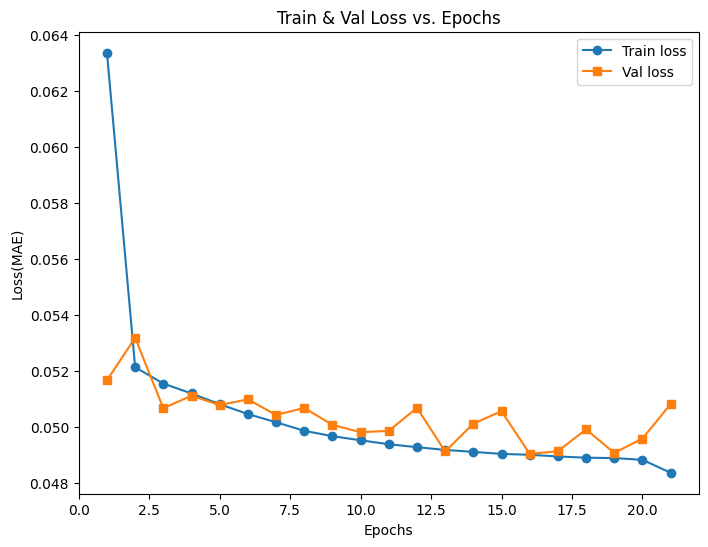

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import copy

HORIZONS = list(range(1,16))
LOOKBACK = 60
BATCH = 32
HIDDEN = 96
LR = 5e-4
WD = 1e-4
EPOCHS = 50

def make_dataset(data, lookback=60, horizons=None, stride=1):

    X, y = [], []
    max_h = max(horizons)
    for i in range(0, len(data)-lookback-max_h+1, stride):
      X.append(data[i:i+lookback,:])
      y.append(np.stack([data[i+lookback+h-1,:] for h in horizons], axis=0))
    return np.array(X, np.float32), np.array(y, np.float32)

# ======================================= Data Preparing =========================================================
train_data = train_flow_speed.values
val_data = val_flow_speed.values
test_data = test_flow_speed.values

scaler = MinMaxScaler((0,1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

X_train,y_train = make_dataset(train_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_val,y_val = make_dataset(val_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_test,y_test = make_dataset(test_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)

# transform numpy to tensor & float32
X_train = torch.from_numpy(X_train).float()   # [N,L,2*8]
y_train = torch.from_numpy(y_train).float()   # [N,H,2*8]
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset,batch_size=BATCH,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH,shuffle=False)


# ====================== Instantiate a model & Set Loss Fcunction & Optimzier ==============================
D = train_flow_speed.shape[1]  # number of portals * 2 (two features: flow & speed)
lstm_all = SimpleLSTM(input_size=D, hidden_size=HIDDEN, num_layers=1, horizon=len(HORIZONS), out_size=D)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(lstm_all.parameters(),lr=LR,weight_decay=WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
)

# ===================== Training and test loop ==================================================================
train_losses, val_losses = [], []
best_val, best_state, wait = float("inf"), None, 0
patience_es = 5

start_time = timer()
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n---------")
  train_loss = train_step(lstm_all,train_dataloader,loss_fn,optimizer,device)
  val_loss = test_step(lstm_all,val_dataloader,loss_fn,device)
  scheduler.step(val_loss)
  # print("current lr:", optimizer.param_groups[0]["lr"])

  train_losses.append(train_loss)
  val_losses.append(val_loss)     # for plot

  # Early Stopping
  if val_loss < best_val - 1e-6:
    best_val, best_state, wait = val_loss, copy.deepcopy(lstm_all.state_dict()), 0
  else:
    wait += 1
    if wait >= patience_es:
      print(f"Early stopping triggered at epoch {epoch}. Best val loss = {best_val:.5f}")
      break

if best_state is not None:
  lstm_all.load_state_dict(best_state)

end_time = timer()
total_time = print_train_time(start_time, end_time, device=device)

### Visualize
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker = "o", label="Train loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker = "s", label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss(MAE)")
plt.title("Train & Val Loss vs. Epochs")
plt.legend()
plt.show()

In [ ]:
# torch.save(lstm_all.state_dict(), "lstm_model.pth")

In [ ]:
# Final Test evaluation
metrics,y_true,y_pred = eval_model(model=lstm_all,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      device=device,
      scaler=scaler,
      horizons=HORIZONS,
      feature_names=feature_cols)
print(metrics["MAE_overall"], metrics["RMSE_overall"])
metrics["per_step_df"]

4.100499629974365 7.515174388885498


,feature,horizon,MAE,RMSE
0,FLOW,1,6.070453,8.389551
1,FLOW,2,6.564355,9.089897
2,FLOW,3,6.703927,9.387969
3,FLOW,4,6.814959,9.611795
4,FLOW,5,6.936618,9.827315
5,FLOW,6,7.105886,10.154669
6,FLOW,7,7.243919,10.416031
7,FLOW,8,7.363273,10.599627
8,FLOW,9,7.475886,10.805121
9,FLOW,10,7.581395,10.978908


In [ ]:
metrics["per_step_df"].to_csv("lstm_evaluation_results.csv")

# GCN + LSTM

In [ ]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
val_df["datetime"] = pd.to_datetime(val_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

In [ ]:
portal_ids = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
        "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]

In [ ]:
def id_to_pos(pid: str) -> int:
  """
    Transform the numbers in the portal id into a "meter mark",
    for calculating distance later
  """
  s = pid.replace("E4S", "").replace(",", "")
  s = s.strip()
  return int(s)

In [ ]:
pos = np.array([id_to_pos(p) for p in portal_ids], dtype=np.float32)
d_nn = np.abs(np.diff(pos))
# choose the 0.5*median of adjacent distances as sigma, for calculating Gaussian kernel (weighted adjacency)
median = np.median(d_nn)
sigma = median * 0.5
sigma

np.float32(165.0)

In [ ]:
def weight_gaussian(d, sigma):
  """
    Gaussian kernel as weight function
  """
  return np.exp(-(d**2)/(2*sigma**2))

In [ ]:
def build_Ahat(portal_ids, sigma, device:torch.device=device):

  N = len(portal_ids)
  pos = np.array([id_to_pos(p) for p in portal_ids], dtype=np.float32)
  order = np.argsort(-pos)

  # build an adjacency matrix A
  A = np.zeros((N,N),dtype=np.float32)
  for k in range(N-1):
    up, down = order[k], order[k+1]
    d = np.abs(pos[up] - pos[down])
    w = weight_gaussian(d, sigma)
    A[down, up] = w

  # A self_connections
  A_wavy = A + np.eye(N, dtype=np.float32)
  # D: degree matrix
  D = A_wavy.sum(axis=1)
  # D^(-1/2)
  D_inv_sqrt_vec = np.power(D, -0.5, where=D>0).astype(np.float32)
  D_inv_sqrt_mat = np.diag(D_inv_sqrt_vec)
  # A_hat
  A_hat_t = D_inv_sqrt_mat @ A_wavy @ D_inv_sqrt_mat
  A_hat_t = torch.from_numpy(A_hat_t).float()
  A_hat_t = A_hat_t.to(device)
  return A_hat_t

In [ ]:
class TwoLayerGCN(nn.Module):
  def __init__(self, A_hat: torch.Tensor, in_feat, hidden_size, out_feat, dropout: float = 0.0):
    super().__init__()
    self.in_feat = in_feat
    self.hidden_size = hidden_size
    self.out_feat = out_feat
    self.register_buffer("A_hat", A_hat)

    self.lin1 = nn.Linear(in_features=in_feat, out_features=hidden_size)
    self.lin2 = nn.Linear(in_features=hidden_size, out_features=out_feat)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(dropout)

  def _gcn_once(self, X: torch.Tensor) -> torch.Tensor:
    """
      H1: ReLU(A_hat@X@W0)
      Y: A_hat@H1@W1
      X：[B，N, Feature_in]: (batch_size, nodes, input_features)
      Y：[B, N, Feature_out]: (batch_size, nodes, output_features)
      one time step
    """
    H = torch.matmul(self.A_hat, X)              # [B,N,F_in]
    H = self.lin1(H)                      # [B,N,hidden]
    H = self.relu(H)
    H = self.drop(H)
    Y = torch.matmul(self.A_hat, H)              # [B,N,hidden]
    Y = self.lin2(Y)                      # [B,N,F_out]
    return Y

  def forward(self, X:torch.Tensor) -> torch.Tensor:
    if X.dim() == 3: #[B,N,F]
      return self._gcn_once(X)
    elif X.dim() == 4: #[B,L,N,F]
      B, L, N, F = X.shape
      X = X.reshape(B*L, N, F)
      Y = self._gcn_once(X) #[B*L,N,F]
      Y = Y.reshape(B,L,N,self.out_feat)
      return Y
    else:
      raise ValueError("Input dimension should be 3[B,N,F] or 4[B,L,N,F]")

In [ ]:
class TwoLayerGCN_LSTM(nn.Module):
  def __init__(self, A_hat: torch.Tensor, in_feat: int=2, gcn_hidden: int=16, gcn_out: int=8, gcn_dropout: float=0.2,
         lstm_hidden: int=96, lstm_layers=1, out_feat: int=2, horizon: int=15, N: int=8):
    super().__init__()
    self.in_feat = in_feat
    self.gcn_out = gcn_out
    self.out_feat = out_feat
    self.horizon = horizon
    self.N = N

    self.gcn = TwoLayerGCN(A_hat=A_hat, in_feat=in_feat, hidden_size=gcn_hidden, out_feat=gcn_out, dropout=gcn_dropout)
    # self.in_drop = nn.Dropout(0.1)
    self.lstm = nn.LSTM(input_size=N*gcn_out, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
    # self.out_drop = nn.Dropout(0.1)
    self.linear = nn.Linear(in_features=lstm_hidden,
                 out_features=horizon*N*out_feat)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    """
    x: [B, L, N*F(2*N)]
    -> [B, L, N, F] GCN
    -> [B, L, N*F] LSTM
    """
    B, L, D = x.shape
    assert D == self.N * self.in_feat
    # [B,L,N*F] --> [B,L,N,F] feed to GCN
    x = x.reshape(B,L,self.N,self.in_feat)
    g = self.gcn(x) # [B,L,N,GCN_OUT]
    g = g.reshape(B,L,self.N*self.gcn_out)
    # g = self.in_drop(g)
    lstm_out, (h_n,c_n) = self.lstm(g)
    # lstm_out = self.out_drop(lstm_out)
    y = self.linear(lstm_out[:,-1,:])   # [B,H*N*F]
    y = y.view(-1,self.horizon,self.N,self.out_feat) # [B,H,N,F]
    y = y.reshape(B,self.horizon,self.N*self.out_feat) # [B,H,N*F]
    return y

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.06517
Test loss: 0.05732
Epoch: 1
---------
Train loss: 0.05341
Test loss: 0.05594
Epoch: 2
---------
Train loss: 0.05228
Test loss: 0.05482
Epoch: 3
---------
Train loss: 0.05174
Test loss: 0.05372
Epoch: 4
---------
Train loss: 0.05126
Test loss: 0.05393
Epoch: 5
---------
Train loss: 0.05084
Test loss: 0.05175
Epoch: 6
---------
Train loss: 0.05062
Test loss: 0.05328
Epoch: 7
---------
Train loss: 0.05042
Test loss: 0.05357
Epoch: 8
---------
Train loss: 0.05027
Test loss: 0.05277
Epoch: 9
---------
Train loss: 0.05016
Test loss: 0.05141
Epoch: 10
---------
Train loss: 0.05006
Test loss: 0.05218
Epoch: 11
---------
Train loss: 0.05000
Test loss: 0.05081
Epoch: 12
---------
Train loss: 0.04991
Test loss: 0.05103
Epoch: 13
---------
Train loss: 0.04983
Test loss: 0.05145
Epoch: 14
---------
Train loss: 0.04979
Test loss: 0.05164
Epoch: 15
---------
Train loss: 0.04967
Test loss: 0.05137
Epoch: 16
---------
Train loss: 0.04927
Test loss: 0.05088
Early s

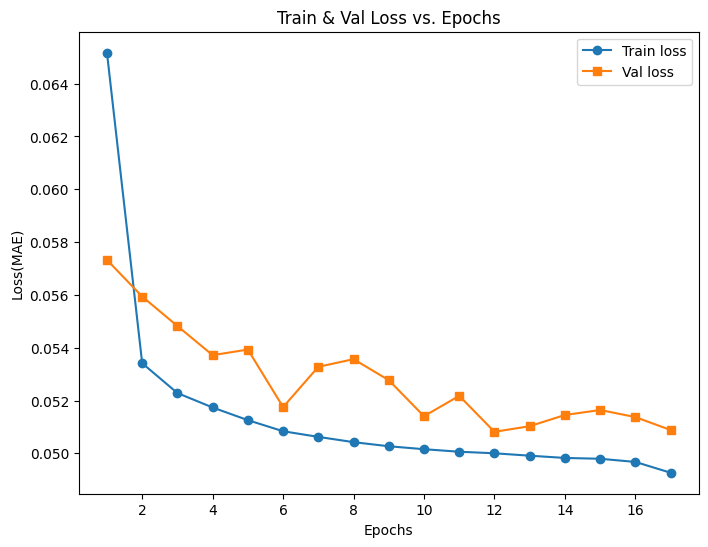

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import copy

HORIZONS = list(range(1,16))
LOOKBACK = 60
BATCH = 32
GCN_HIDDEN = 16
GCN_OUT = 8
GCN_DROPOUT = 0.2
LSTM_HIDDEN = 96
LR = 5e-4
WD = 1e-4
EPOCHS = 50
N = len(portal_ids)
A_hat = build_Ahat(portal_ids, sigma, device=device)

def make_dataset(data, lookback=60, horizons=None, stride=1):
  X, y = [], []
  max_h = max(horizons)
  for i in range(0, len(data)-lookback-max_h+1, stride):
    X.append(data[i:i+lookback,:])
    y.append(np.stack([data[i+lookback+h-1,:] for h in horizons], axis=0))
  return np.array(X, np.float32), np.array(y, np.float32)

# ======================================= Data Preparing =========================================================
train_data = train_flow_speed.values
val_data = val_flow_speed.values
test_data = test_flow_speed.values

scaler = MinMaxScaler((0,1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

X_train,y_train = make_dataset(train_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_val,y_val = make_dataset(val_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_test,y_test = make_dataset(test_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)

# transform numpy to tensor & float32
X_train = torch.from_numpy(X_train).float()   # [N,L,2*8]
y_train = torch.from_numpy(y_train).float()   # [N,H,2*8]
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset,batch_size=BATCH,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH,shuffle=False)


# ====================== Instantiate a model & Set Loss Fcunction & Optimzier ==============================

gcn_lstm = TwoLayerGCN_LSTM(A_hat=A_hat, in_feat=2, gcn_hidden=GCN_HIDDEN, gcn_out=GCN_OUT, gcn_dropout=GCN_DROPOUT,
         lstm_hidden=LSTM_HIDDEN, lstm_layers=1, out_feat=2, horizon=len(HORIZONS), N=N)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(gcn_lstm.parameters(),lr=LR,weight_decay=WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
)

# ===================== Training and test loop ==================================================================
train_losses, val_losses = [], []
best_val, best_state, wait = float("inf"), None, 0
patience_es = 5

start_time = timer()
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n---------")
  train_loss = train_step(gcn_lstm,train_dataloader,loss_fn,optimizer,device)
  val_loss = test_step(gcn_lstm,val_dataloader,loss_fn,device)
  scheduler.step(val_loss)
  # print("current lr:", optimizer.param_groups[0]["lr"])

  train_losses.append(train_loss)
  val_losses.append(val_loss)     # for plot

  # Early Stopping
  if val_loss < best_val - 1e-6:
    best_val, best_state, wait = val_loss, copy.deepcopy(gcn_lstm.state_dict()), 0
  else:
    wait += 1
    if wait >= patience_es:
      print(f"Early stopping triggered at epoch {epoch}. Best val loss = {best_val:.5f}")
      break

if best_state is not None:
  gcn_lstm.load_state_dict(best_state)

end_time = timer()
total_time = print_train_time(start_time, end_time, device=device)

### Visualize
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker = "o", label="Train loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker = "s", label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss(MAE)")
plt.title("Train & Val Loss vs. Epochs")
plt.legend()
plt.show()

In [ ]:
# torch.save(gcn_lstm.state_dict(), "gcn_lstm_model.pth")

In [ ]:
# final test evaluation
metrics,y_true,y_pred = eval_model(model=gcn_lstm,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      device=device,
      scaler=scaler,
      horizons=HORIZONS,
      feature_names=feature_cols)
print(metrics["MAE_overall"], metrics["RMSE_overall"])
metrics["per_step_df"]

4.172072887420654 7.600302219390869


,feature,horizon,MAE,RMSE
0,FLOW,1,6.020730,8.376086
1,FLOW,2,6.556575,9.112274
2,FLOW,3,6.756451,9.471516
3,FLOW,4,6.854597,9.692086
4,FLOW,5,6.940675,9.861061
5,FLOW,6,7.164423,10.255742
6,FLOW,7,7.290395,10.488647
7,FLOW,8,7.418433,10.681487
8,FLOW,9,7.559616,10.886082
9,FLOW,10,7.675761,11.045913


In [ ]:
metrics["per_step_df"].to_csv("gcn_lstm_evaluation_results.csv")